In [ ]:
# Utils
import time
from tqdm import tqdm

# Data Structures
import heapq

# Data Manipulation and computations
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
class Node:
  
  def __init__(self, parent=None, position=None, recency_factor=None):
    """ 
    Represents a Node in the A* search tree. 
    
    Parameters
    ----------
    parent: Node
      Node for the neighbouring cell from which this node was discovered
    position: (int, int)
      Coordinates of the cell.
    recency_factor: int
      Represents how recently this node was created. Used for breaking ties in
      the priority queue.
    """

    self.parent = parent
    self.position = position
    self.recency_factor = recency_factor

    self.g = 0
    self.h = 0
    self.f = 0
  
  def __eq__(self, other):
    """ 
    For Node comparison. 
    
    Parameters
    ----------
    other: Node
      The object with which this instance needs to be compared.
    """

    # In case 'other' is not a Node
    if type(self) != type(other):
      return False

    return self.position == other.position
  
  def __lt__(self, other):
    """ 
    For heap comparison. 
    
    Parameters
    ----------
    other: Node
      The object with which this instance needs to be compared.
    """

    if self.f < other.f:  # If priority is less
      return True
    elif self.f == other.f:  # If tie, check recency
      if self.recency_factor > other.recency_factor:
        return True
    
    return False


  def __gt__(self, other):
    """
    For heap comparison. 
    
    Parameters
    ----------
    other: Node
      The object with which this instance needs to be compared.
    """

    if self.f > other.f:  # If priority is more
      return True
    elif self.f == other.f:  # If tie, check recency
      if self.recency_factor < other.recency_factor:
        return True
    
    return False



def is_unvisited_and_unblocked(coords, state):
  """
  Checks if a cell is not blocked and not yet visited.
  
  Parameters
  ----------
  coords: (int, int)
    Coordinates of the cell to check
  state: (2D np.array, 2D np.array, 2D np.array)
    The elements are passed in the following order:
      `knowledge` - Represents the knowledge of the agent. knowledge[x][y] = 1 if
        the agent knows there exists a block at position (x, y) and is 0 otherwise.
      `visited` - Represents which nodes the agent has already expanded. visited[x][y] = 1 if
        the agent has already expanded Node at (x, y) and 0 otherwise.
      `in_fringe` - Represents if the node is in the fringe already. in_fringe[x][y] = 1
        if Node at (x, y) is already in the fringe and 0 otherwise.

  Returns
  -------
  True if not blocked and not visited else False
  """

  # Get coordinates
  x, y = coords
  knowledge, visited, _ = state

  # Return false if cell is blocked or already visited
  if knowledge[x][y] != 0 or visited[x][y] != 0:
    return False

  return True

def neighbourhood(coords, num_rows, num_cols, nbhd_type="compass", parent_coords=None):
  """
  Returns the possible neighbours of a cell. Doesn't check for visited or blocked nodes.
  Assumes the grid is between `(0, 0)` to `(num_rows-1, num_cols-1)`. 

  Parameters
  ----------
  coords: (int, int)
    Coordinates of the cell
  num_rows: int
    No. of rows in the grid.
  num_cols: int
    No. of columns in the grid.
  nbhd_type: str
    `compass` - the agent can see in all 4 directions (up, down, left, right)
    `directional` - the agent can only see in the direction in which it is moving
  parent_coords: (int, int)
    Coordinates of the parent cell, required if `nbhd_type` is `directional`.

  Returns
  -------
  possible_cells: List[(int, int)]
    List of coordinates for the possible neighbours
  """

  if nbhd_type == "compass":

    # Get possible cells
    x, y = coords
    possible_cells = [(x+1, y), (x, y+1), (x-1, y), (x, y-1)]

    # Remove cells outside boundaries
    possible_cells = [cell for cell in possible_cells if cell[0] >= 0 and cell[1] >= 0 and cell[0] <= num_rows-1 and cell[1] <= num_cols-1]

    return possible_cells
  
  elif nbhd_type == "directional":

    if parent_coords is None:
      raise ValueError("Parent coords cannot be none if nbhd_type == 'directional'.")

    # Find the possible neighbouring node in the field of view
    cell = tuple(np.array(coords) + (np.array(coords) - np.array(parent_coords)))

    # Check if the node is valid
    possible_cells = [cell] if cell[0] >= 0 and cell[1] >= 0 and cell[0] <= num_rows-1 and cell[1] <= num_cols-1 else []

    return possible_cells
  
  raise ValueError("nbhd type can only be from ['compass', 'directional'], not", nbhd_type)

def get_valid_children(coords, parent, num_rows, num_cols, state):
  """
  Gets valid children for a cell, based on position, known blockages and visited
  neighbours.

  Parameters
  ----------
  coords: (int, int)
    Coordinates of the cell
  parent: Node
    Parent of the cell for which the neighbours need to be created
  num_rows: int
    No. of rows in the grid.
  num_cols: int
    No. of columns in the grid.
  state: (2D np.array, 2D np.array, 2D np.array)
    The elements are passed in the following order:
      `knowledge` - Represents the knowledge of the agent. knowledge[x][y] = 1 if
        the agent knows there exists a block at position (x, y) and is 0 otherwise.
      `visited` - Represents which nodes the agent has already expanded. visited[x][y] = 1 if
        the agent has already expanded Node at (x, y) and 0 otherwise.
      `in_fringe` - Represents if the node is in the fringe already. in_fringe[x][y] = 1
        if Node at (x, y) is already in the fringe and 0 otherwise.

  Returns
  -------
  valid_children: List[(int, int)]
    List of the possible coordinates of the children.
  """

  # Get all possible children
  nbhd = neighbourhood(coords, num_rows, num_cols)

  # Don't add the parent to the list of valid children
  if parent is not None:
    nbhd = [x for x in nbhd if x != parent.position]

  # Remove known blocked and visited cells
  valid_children = [cell for cell in nbhd if is_unvisited_and_unblocked(cell, state)]

  return valid_children

In [ ]:
def generate_gridworld(shape, block_prob):
  """
  Parameters
  ----------
  shape: (int, int)
    Number of rows and columns in the required gridworld
  block_prob: float
    Each cell is blocked with a probability p = block_prob

  Returns
  -------
  grid_world: 2D np.array
    Grid with each cell blocked with a probability `block_prob`.
  """

  num_rows, num_cols = shape

  # Randomly sample a 2D array with each cell being either 1 or 0 with prob as block_prob
  grid_world = np.random.choice([1, 0], (num_rows, num_cols), p=[block_prob, 1-block_prob])

  # Exclude start and end cells
  grid_world[0][0] = 0
  grid_world[num_rows-1][num_cols-1] = 0

  return grid_world

In [ ]:
def grid_path(current_node):
    """ 
    Recursively finds the path from the leaf to the root node in the A* search tree. 
    
    Parameters
    ----------
    current_node: Node
      Node in the A* search tree.

    Returns
    -------
    planned_path: List[(int, int)]
      Path from the root node to this leaf node
    """

    path = []

    # Recursively travel up to the root
    current = current_node

    while current != None:
      path.append(current.position)
      current = current.parent

    # Reverse and return
    return path[::-1]
  
def heuristic(name, start, end):
    """ 
    Returns the heuristic (distance) between the start and end cells. 

    Parameters
    ----------
    name: str
      Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`.
    start: (int, int)
      Coordinates of the start cell
    end: (int, int)
      Coordinates of the end cell

    Returns
    -------
    distance: float or int
      Distance based on which heuristic is being used.
    """

    if name == "euclidean":
      return dist.euclidean(start, end)
    elif name == "manhattan":
      return dist.cityblock(start, end)
    elif name == "chebyshev":
      return dist.chebyshev(start, end)

    # If heuristic is unknown, raise error
    raise NotImplementedError("Unknown heuristic:", name)


def a_star_search(start, goal, grid, heuristic_type, 
                  visited, knowledge, max_steps=None, 
                  epsilon=1.):
  """ 
  Executes A* search on a grid.

  Parameters
  ----------
  start: (int, int)
    Coordinates of the start cell.
  goal: (int, int)
    Coordinates of the goal cell.
  grid: 2D np.array
    Represents the original grid on which A* needs to be executed
  heuristic_type: str
    Type of heuristic to use. Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
  visited: 2D np.array
    Represents which nodes the agent has already expanded. visited[x][y] = 1 if
    the agent has already expanded Node at (x, y) and 0 otherwise.
  knowledge: 2D np.array
    Represents the knowledge of the agent. knowledge[x][y] = 1 if
    the agent knows there exists a block at position (x, y) and is 0 otherwise.
  max_steps: int or None
    Max. number of times we pop a Node from the Fringe
  epsilon: float
    Weight given to the heuristic function while calculating the priority f. Used as:
    f(n) = g(n) + epsilon*h(n)

  Returns
  -------
  planned_path: List[(int, int)]
    List of cells to traverse from the start node to end node
  exit_status: str
    `"SUCCESS"` - If A* was successfully completed
    `"FAILED_NOPATH"` - If no path can be found from the start to the goal cells
    `"FAILED_STEPS"` - Max. number of steps was reached and path not found
  num_cells_popped: int
    Total number of nodes popped from the fringe throughout the search process.
  
  TODO
  ----
  - num_cells_popped == steps? Remove num_cells_popped and use steps instead
  - Remove the `grid` parameter since this is not required
  - Implement a separate `Fringe` class
  """

  start_node = Node(position=start)
  goal_node = Node(position=goal)

  # Implementing priority queue using heap
  fringe = []
  in_fringe = np.zeros(grid.shape)
  heapq.heapify(fringe)

  # Initialize tracking parameters
  recency_counter = 0
  num_cells_popped = 0

  # Add start node to the fringe
  start_node.recency_factor = recency_counter
  heapq.heappush(fringe, start_node)
  in_fringe[start[0]][start[1]] = 1
  recency_counter += 1
  
  # Stopping condition
  if max_steps is None:
    max_steps = grid.shape[0]**2 * grid.shape[1]**2

  steps = 0
  exit_status = "FAILED_NOPATH"

  # Start
  while fringe:
    
    steps += 1

    # Pop the current node from the fringe
    current_node = heapq.heappop(fringe)
    num_cells_popped += 1
    curr_x, curr_y = current_node.position

    # Visit the current node and note that it is out of the fringe
    visited[curr_x][curr_y] = 1
    in_fringe[curr_x][curr_y] = 0

    # Check and return path if we have reached the goal node
    if current_node == goal_node:
      exit_status = "SUCCESS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Stopping condition
    if steps > max_steps:
      exit_status = "FAILED_STEPS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Create children
    children = get_valid_children(current_node.position, current_node.parent, grid.shape[0], grid.shape[1], (knowledge, visited, in_fringe))
    children = [Node(current_node, x) for x in children]

    # Set parameters for each child
    for i in range(len(children)):
      children[i].g = current_node.g + 1
      children[i].h = heuristic(heuristic_type, children[i].position, goal)
      children[i].f = children[i].g + epsilon*children[i].h
      children[i].recency_factor = recency_counter

      heapq.heappush(fringe, children[i])
      in_fringe[children[i].position[0]][children[i].position[1]] = 1

      recency_counter += 1

  return [], exit_status, num_cells_popped

In [ ]:
def visualize_grid(sol, grid):
  """
  Visualize grid with the solution on top of it, marked by `*`.

  Parameters
  ----------
  sol: List[(int, int)]
    List of cells in the path from the start to end node
  grid: 2D np.array
    Grid on which to superimpose the solution

  Returns
  -------
  vis_grid: 2D np.array
    The grid to visualize. Use with `pretty_print`.
  """

  # Create copy of the original grid
  vis_grid = grid.copy().astype(str)

  # Mark path on grid
  for cell in sol:
    vis_grid[cell[0]][cell[1]] = "*"

  return vis_grid

def pretty_print(A):
  """
  Prints a 2D np.array with good visual clarity
  
  Parameters
  ----------
  A: 2D np.array
    The grid to visualize
  """
  print('\n'.join([''.join(['{:4}'.format(item) for item in row]) for row in A]))

In [ ]:
def test_a_star_search_custom():
  grid = [[0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
          [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
          [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
          [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
          [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
          [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
          [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
          [1, 1, 0, 1, 0, 0, 0, 0, 1, 0]]

  grid = np.array(grid)

  visited = np.zeros(grid.shape)
  blocked = grid.copy()

  sol = a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "euclidean", visited, blocked)

  pretty_print(grid)
  print("\n")
  pretty_print(visualize_grid(sol, grid))

In [ ]:
grid = np.array([[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
              [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
              [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
              [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
              [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
              [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
              [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]])



knowledge = np.array([[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
                    [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
                    [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
a_star_search((0, 9), (0, 7), grid, "manhattan", np.zeros(grid.shape), knowledge)

([(0, 9),
  (0, 10),
  (1, 10),
  (2, 10),
  (3, 10),
  (3, 9),
  (3, 8),
  (3, 7),
  (4, 7),
  (5, 7),
  (6, 7),
  (7, 7),
  (8, 7),
  (8, 6),
  (9, 6),
  (10, 6),
  (10, 5),
  (11, 5),
  (11, 4),
  (11, 3),
  (11, 2),
  (11, 1),
  (11, 0),
  (12, 0)],
 'FAILED_STEPS',
 50626)

In [ ]:
def is_open_cell(cell, knowledge):
  """
  Checks if a cell is open, i.e., has 3 or more unblocked neighbours.

  Parameters
  ----------
  cell: (int, int)
    Coordinates of the cell for which to check
  knowledge: 2D np.array
    Represents the knowledge of the agent. knowledge[x][y] = 1 if
    the agent knows there exists a block at position (x, y) and is 0 otherwise.
  """

  # Get neighbourhood of the cell
  nbhd = neighbourhood(cell, knowledge.shape[0], knowledge.shape[1])

  # Retain only the unblocked ones
  unblocked = [nbr for nbr in nbhd if knowledge[nbr[0]][nbr[1]] != 1]

  # Check length of unblocked cells
  if len(unblocked) >= 3:
    return True

  return False

In [ ]:
grid = [[0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 1, 0]]

grid = np.array(grid)

is_open_cell((0, 1), grid)

False

In [ ]:
def move_and_record(start, goal, grid, planned_path, knowledge, nbhd_type="compass"):
  """
  Moves the robot along the path and records the environment as it travels.
  If a block is encountered, returns the last unblocked location.

  Parameters
  ----------
  start: (int, int)
    The start coordinates in the grid. Between (0, 0) and 
    (grid.shape[0]-1, grid.shape[1]-1).
  goal: (int, int) 
    The goal coordinates in the grid. Limits are similar to start.
  planned_path: List[(int, int)]
    List of coordinates (including start and end) to visit.
  knowledge: 2D np.array
    Represents the knowledge of the agent. knowledge[x][y] = 1 if
    the agent knows there exists a block at position (x, y) and is 0 otherwise.
  nbhd_type: str
    `'compass'` if the agent can see in all 4 directions while moving and
    `'directional'` if the agent can see only in the direction it is moving in
  
  Returns
  -------
  final_node: (int, int)
    The last unblocked node visited or the goal node.
  knowledge: 2D np.array
    Updated knowledge array.
  steps: int
    Number of steps taken along the path.
  last_open_cell: (int, int)
    The last cell seen with no. of unblocked neighbours >= 3
  """

  if not planned_path:  # Planned path is empty
    raise ValueError("Planned path cannot be empty.")

  if planned_path[0] != start:  # Planned path and start don't coincide
    raise ValueError("Planned path doesn't start with 'start'! planned_path[0] =", 
                     planned_path[0], "start =", start)

  steps = 0
  last_open_cell = None

  # Start moving
  for i in range(len(planned_path)):
    cell = planned_path[i]

    # If cell is blocked, return the last known location
    if grid[cell[0]][cell[1]] == 1:
      knowledge[cell[0]][cell[1]] = 1
      return planned_path[i-1], knowledge, steps, last_open_cell

    # Find all neighbouring cells and update knowledge
    parent_coords = planned_path[i-1] if i-1 > 0 else tuple(np.array(cell) - (np.array(planned_path[i+1]) - np.array(cell)))
    nbhd = neighbourhood(cell, grid.shape[0], grid.shape[1], nbhd_type=nbhd_type, parent_coords=parent_coords)

    # 'See' the whole neighbourhood
    for nbr in nbhd:
      knowledge[nbr[0]][nbr[1]] = grid[nbr[0]][nbr[1]]

    # If this cell is open, update last_open_cell
    if is_open_cell(cell, knowledge):
      last_open_cell = cell

    steps += 1

  return planned_path[i], knowledge, steps, last_open_cell

In [ ]:
class RepeatedAStar:

  def __init__(self, grid, move_nbhd_type="compass", epsilon=1., 
               escape_tunnels=False):
    """ 
    Implements the Repeated A* algorithm on a grid-world. 
    
    Parameters
    ----------
    grid: 2D np.array
      The grid world on which we need to implement the algorithm
    move_nbhd_type: str
      Can be 'compass' (see in all 4 directions in the execution phase) 
      or 'directional' (see in only the direction of the movement 
      in the execution phase)
    epsilon: float
      Weight with which the heuristic function is multiplied, as:
      f(n) = g(n) + epsilon*h(n)
    escape_tunnels: bool
      Set to true to restart A* from the start of a tunnel by backtracking
      instead of dead-ends
    """

    # Logging
    self.knowledge_snaps = []
    self.visited_snaps = []
    self.start_end_snaps = []
    self.sol_snaps = []
    self.step = 0
    self.successfully_completed = False
    self.final_exit_status = None
    self.grid = grid
    self.total_cells_processed_by_run = []
    self.backtracks = []

    # Algorithm parameters
    self.epsilon = epsilon
    self.move_nbhd_type = move_nbhd_type
    self.escape_tunnels = escape_tunnels

  def _update_state(self, knowledge, visited, path_end_points, soln, 
                    step, successfully_completed, final_exit_status, 
                    num_cells_popped):
    """ 
    Updates the state (logging variables) after each run of the planning + execution phases. 
    
    Parameters
    ----------
    knowledge: 2D np.array
      Represents the knowledge of the agent. knowledge[x][y] = 1 if
      the agent knows there exists a block at position (x, y) and is 0 otherwise.
    visited: 2D np.array
      Represents which nodes the agent has already expanded. visited[x][y] = 1 if
      the agent has already expanded Node at (x, y) and 0 otherwise.
    path_end_points: ((int, int), (int, int))
      Start and end points for 1 run of A* search
    soln: List[(int, int)]
      Planned path from the start node to the end node for 1 run of A* search
    step: int
      The step number for repeated A* search
    successfully_completed: bool
      If goal node has been reached by repeated A* search
    final_exit_status: str
      `"SUCCESS"` - If A* was successfully completed
      `"RUNNING"` - If Repeated A* search is still running
      `"FAILED_NOPATH"` - A* search could not find a path between the start and end nodes
      `"FAILED_STEPS"` - No. of steps in 1 run of A* search exceeded max steps
      `"FAILED_STEPS_REP"` - No. of steps for repeated A* search exceeded max steps
    num_cells_popped: int
      Number of cells popped during one run of A* search


    TODO
    ----
    - Add backtracks to the final path
    """
    
    self.knowledge_snaps.append(knowledge)
    self.visited_snaps.append(visited)
    self.start_end_snaps.append(path_end_points)
    self.sol_snaps.append(soln)
    self.step = step
    self.successfully_completed = successfully_completed
    self.final_exit_status = final_exit_status
    self.total_cells_processed_by_run.append(num_cells_popped)

  def logs(self):
    """
    Fetches all the logging parameters

    Returns
    -------
    log: Dict[str, Any]
      All logging vars added to a dictionary
    """
    return {
        "grid": self.grid,
        "knowledge": self.knowledge_snaps,
        "visited": self.visited_snaps,
        "start_end": self.start_end_snaps,
        "solns": self.sol_snaps,
        "num_steps": self.step,
        "successfully_completed": self.successfully_completed,
        "final_exit_status": self.final_exit_status
    }

  def path_followed(self):
    """ Returns the actual path followed (planning + execution) """

    # If the paths followed and solutions don't match
    assert len(self.sol_snaps) == len(self.start_end_snaps), \
      "More steps for A* than elements in start_end."
    
    full_path = []
    for i in range(len(self.start_end_snaps)):

      # Get index of end node in path
      _, end_node = self.start_end_snaps[i]
      end_index = self.sol_snaps[i].index(end_node)

      # Clip the array according to end index and append to parent array
      clipped_array = self.sol_snaps[i][:end_index]
      full_path += clipped_array

    return full_path

  def total_cells_processed(self):
    """
    Returns total number of Nodes popped from the Fringe across each run of A* search.
    """
    
    return sum(self.total_cells_processed_by_run)

  def total_backtracked_cells(self):
    """ 
    Returns total number of cells backtracked to the start of a tunnel.
    """

    flat_list = [item for sublist in self.backtracks for item in sublist]
    return len(flat_list)

  def search(self, start, goal, grid, heuristic_type, 
             max_steps_astar=None, max_steps_repeated=None):
    """
    Performs the repeated search on a grid.

    Parameters
    ----------
    start: (int, int)
      Coordinates of the start node
    goal: (int, int)
      Coordinates of the goal node
    grid: 2D np.array
      Original gridworld on which to perform grid search
    heuristic_type: str
      Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
    max_steps_astar: int
      Max. no. of steps for 1 run of A* search
    max_steps_repeated: int
      Max. no. of steps for 1 run of Repeated A* search
    """

    # Exit condition
    if max_steps_repeated is None:
      max_steps_repeated = grid.shape[0]*grid.shape[1]

    # Initialize visited matrix, knowledge matrix and planned_path array
    knowledge = np.zeros(grid.shape)
    
    # Start
    while not self.successfully_completed:

      # If number of steps have been exceeded for Repeated A*
      if self.step > max_steps_repeated:
        self._update_state(None, None, (None, None),
                           None, self.step, False,
                           "FAILED_STEPS_REP", 0)
        return

      visited = np.zeros(grid.shape)

      # Run A* search algorithm once
      planned_path, exit_status, num_cells_popped = \
        a_star_search(start, goal, grid, heuristic_type, 
                      visited, knowledge, max_steps=max_steps_astar, 
                      epsilon=self.epsilon)

      # If no path can be found
      if exit_status == "FAILED_NOPATH":
        self._update_state(knowledge, visited, (start, None), 
                           planned_path, self.step + 1, False, 
                           exit_status, num_cells_popped)
        return

      # If num of steps were exceeded for one run of A*
      elif exit_status == "FAILED_STEPS":
        self._update_state(knowledge, visited, (start, None), 
                           planned_path, self.step + 1, False, 
                           exit_status, num_cells_popped)
        return

      # Move robot along the grid on the planned path and record environment
      final_node, knowledge, _, last_open_cell = move_and_record(start, goal, grid, 
                                                                planned_path, knowledge, 
                                                                nbhd_type=self.move_nbhd_type)

      # If we were able to reach the goal successfully
      if final_node == goal:
        self._update_state(knowledge, visited, (start, final_node), 
                           planned_path, self.step + 1, True, 
                           "SUCCESS", num_cells_popped)
        continue

      # If we were not able to reach the goal successfully, repeat until possible
      self._update_state(knowledge, visited, (start, final_node), 
                         planned_path, self.step + 1, False,
                         "RUNNING", num_cells_popped)
      
      # Backtracking to the start of tunnels if this parameter is set, else start from end of last path
      if self.escape_tunnels and last_open_cell is not None and final_node != last_open_cell:
        start = last_open_cell

        loc_idx = planned_path.index(last_open_cell)
        backtrack = reversed(planned_path[loc_idx:])

        self.backtracks.append(backtrack)
      else:
        start = final_node

    # We were able to reach successfully
    return

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7]

last_open_cell = 3
loc_idx = l.index(last_open_cell)
backtrack = list(reversed(l[loc_idx:]))

backtrack

[7, 6, 5, 4, 3]

In [ ]:
def test_repeated_a_star_search_custom(move_nbhd_type="compass", epsilon=1., escape_tunnels=False):
  """ 
  For custom testing of the repeated A* search algorithm. The default grid presents
  a particularly difficult case for A* search. 
  
  Parameters
  ----------
  move_nbhd_type: str
    `'compass'` - Agent can see in all 4 directions while moving
    `'directional'` - Agent can only see in the direction it is moving
  epsilon: float
    Weight given to the heuristic function. Used as:
    f(n) = g(n) * epsilon*h(n)
  escape_tunnels: bool
    Escape tunnels before restarting A* search
  """
  grid = [[0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
          [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
          [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
          [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
          [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
          [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
          [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
          [1, 1, 0, 1, 0, 0, 0, 0, 1, 0]]

  grid = np.array(grid)

  # Run Repeated A* on the grid
  repeated_a_star = RepeatedAStar(grid, move_nbhd_type=move_nbhd_type, epsilon=epsilon, escape_tunnels=escape_tunnels)
  repeated_a_star.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "euclidean")

  # Return the completed R.A* object
  return repeated_a_star

def test_repeated_a_star_search_random(grid_shape, block_prob, 
                                       heuristic_type="euclidean", 
                                       move_nbhd_type="compass", 
                                       solvable=True, 
                                       epsilon=1., 
                                       escape_tunnels=False):
  """ 
  For random testing of the repeated A* search algorithm. 
  
  Parameters
  ----------
  grid_shape: (int, int)
    Shape of the randomly generated gridworld
  block_prob: float
    Each cell in the randomly generated gridworld will be blocked with p = block_prob
  heuristic_type: str
    Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
  move_nbhd_type: str
    `'compass'` - Agent can see in all 4 directions while moving
    `'directional'` - Agent can only see in the direction it is moving
  solvable: bool
    Set to True if the randomly generated gridworld has to be solvable 
  epsilon: float
    Weight given to the heuristic function. Used as:
    f(n) = g(n) * epsilon*h(n)
  escape_tunnels: bool
    Escape tunnels before restarting A* search
  """

  grid = None

  # If the grid needs to be solvable
  if solvable:
    is_solvable = False

    # Keep generating random gridworlds until a solvable one comes up
    while not is_solvable:

      # Generate and check solvability of gridworld
      grid = generate_gridworld(grid_shape, block_prob=block_prob)
      _, exit_status, _ = a_star_search((0, 0), 
                                        (grid.shape[0]-1, grid.shape[1]-1), 
                                        grid, 
                                        heuristic_type, 
                                        np.zeros(grid.shape), 
                                        grid.copy())

      # If gridworld is solvable, break out of loop
      if exit_status == "SUCCESS":
        is_solvable = True
  else:
    # Else generate a random gridworld
    grid = generate_gridworld(grid_shape, block_prob=block_prob)

  t0 = time.time()

  # Run Repeated A* on the grid
  repeated_a_star = RepeatedAStar(grid, move_nbhd_type=move_nbhd_type, epsilon=epsilon, escape_tunnels=escape_tunnels)
  repeated_a_star.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, heuristic_type)

  time_taken = time.time() - t0

  # Return the completed R.A* object and the time taken
  return repeated_a_star, time_taken

In [ ]:
NUM_ITERS = 100
DIM_ROWS, DIM_COLS, P = 101, 101, 0.2
HEURISTIC_FN = "manhattan"

times, statuses = [], []
for _ in tqdm(range(NUM_ITERS)):

  t0 = time.time()

  ras_test, _ = test_repeated_a_star_search_random((DIM_ROWS, DIM_COLS), P, HEURISTIC_FN)

  time_taken = time.time() - t0

  times.append(time_taken)
  statuses.append(ras_test.successfully_completed)

100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


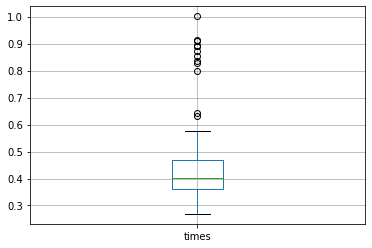

In [ ]:
pd.DataFrame({"times": times}).boxplot()
plt.show()

### Questions

**Question 4:** Solvability A gridworld is solvable if it has a clear path from start to goal nodes. How does solvability depend on p? Given dim = 101, how does solvability depend on p? For a range of p values, estimate the probability that a maze will be solvable by generating multiple environments and checking them for solvability. Plot density vs solvability, and try to identify as accurately as you can the threshold p0 where for p < p0, most mazes are solvable, but p > p0, most mazes are not solvable. Is A* the best search algorithm to use here, to test for solvability? Note for this problem you may assume that the entire gridworld is known, and hence only needs to be searched once each.

In [ ]:
#Finding threshold probability p0 for solvability
res=[]
prob=[]
for i in range(0,100):
  count=0
  prob.append((i/100))
  for j in range(100):
    grid=generate_gridworld((101,101),i/100)
    visited = np.zeros(grid.shape)
    blocked = grid.copy()
    sol, exit_status = a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "manhattan", visited, blocked)
    if exit_status=="SUCCESS":
      count+=1
  count/=10    
  res.append(count)

print(res)

In [ ]:
plt.plot(prob,res)

In [ ]:
for i in range(len(res)):
  if res[i]==5.1:
    print(i)
arr=[]

for i in range(100):
  arr.append(i/100)

plt.xlabel("Probabilty")
plt.ylabel("Solvability")
plt.annotate("p0",xy=(0.29,5.1),)
plt.show()

**Question 5:** Heuristics a) Among environments that are solvable, is one heuristic uniformly better than the other for running A∗? Consider the following heuristics:

– Euclidean Distance $d((x1, y1), (x2, y2)) = ((x1 − x2)^{2} + (y1 − y2))^{0.5}$ (1)

– Manhattan Distance $d((x1, y1), (x2, y2)) = |x1 − x2| + |y1 − y2|$ (2)

– Chebyshev Distance $d((x1, y1), (x2, y2)) = max(|x1 − x2|, |y1 − y2|)$ (3)

How can they be compared? Plot the relevant data and justify your conclusions. Again, you may take each gridworld as known, and thus only search once.

In [ ]:
# For comparison of heuristics

ans=[]
ans2=[]
num_visited = []
count=0
for i in range(100):
  grid=generate_gridworld((101,101),0.28)
  visited = np.zeros(grid.shape)
  blocked = grid.copy()
  sol, exit_status = a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "manhattan", visited, blocked)
  visited = np.zeros(grid.shape)
  if exit_status=="SUCCESS":
    count+=1
    num_visited_in_iter = []

    t0=time.time()
    sol, exit_status = a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "chebyshev", visited, blocked)
    num_visited_in_iter.append(num_nodes_visited(visited))
    visited = np.zeros(grid.shape)
    
    t1=time.time()
    sol2, exit_status2 = a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "manhattan", visited, blocked)
    num_visited_in_iter.append(num_nodes_visited(visited))
    visited = np.zeros(grid.shape)
    

    t2=time.time()
    sol3, exit_status3 = a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "euclidean", visited, blocked)
    num_visited_in_iter.append(num_nodes_visited(visited))

    num_visited.append(num_visited_in_iter)

    if i == 100:
      visited = np.zeros(grid.shape)
    t3=time.time()
    ans2.append([len(sol),len(sol2),len(sol3)])
    temp=[t1-t0,t2-t1,t3-t2]
    ans.append(temp)

In [ ]:
num_nodes_visited = lambda vis: np.where(vis > 0.)[0].shape[0]

In [ ]:
print(np.mean(ans2,axis=0))
print(np.mean(num_visited,axis=0))
print(np.sum(ans,axis=0))
print(count)

In [ ]:
objects = ('Chebyshev', 'Manhattan', 'Euclidean')
y_pos = np.arange(len(objects))
performance = np.mean(num_visited,axis=0)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Nodes Processed')
plt.title('Heuristic')

plt.show()

In [ ]:
objects = ('Chebyshev', 'Manhattan', 'Euclidean')
y_pos = np.arange(len(objects))
performance = np.sum(ans,axis=0)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time taken(579 mazes)')
plt.title('Heuristic')

plt.show()

**Question 6**: Performance Taking dim = 101, for a range of density p values from $0$ to $min(p0 , 0.33)$, and the heuristic chosen as best in Q5, repeatedly generate gridworlds and solve them using Repeated Forward A*. Use as the field of view each immediately adjacent cell in the compass directions. Generate plots of the following data:

* Density vs Average Trajectory Length
* Density vs Average (Length of Trajectory / Length of Shortest Path in Final Discovered Gridworld)
* Density vs Average (Length of Shortest Path in Final Discovered Gridworld / Length of Shortest Path in Full Gridworld)
* Density vs Average Number of Cells Processed by Repeated A*

Discuss your results. Are they as you expected? Explain.

In [ ]:
def block_undiscovered_nodes(path, knowledge):
  new_knowledge = np.ones(knowledge.shape)

  for cell in path:
    new_knowledge[cell[0]][cell[1]] = 0

    nbhd = neighbourhood(cell, knowledge.shape[0], knowledge.shape[1])
    
    for nbr in nbhd:
      new_knowledge[nbr[0]][nbr[1]] = knowledge[nbr[0]][nbr[1]]

  return new_knowledge

In [ ]:
ras, _ = test_repeated_a_star_search_random((15, 15), 0.2, "manhattan")

pretty_print(ras.grid)

   0   0   0   0   0   1   0   0   1   0   0   0   0   1   1
   0   1   1   1   0   0   0   1   0   0   0   0   0   1   0
   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0
   1   1   1   0   1   1   1   0   0   0   0   1   0   0   0
   1   0   0   0   0   0   0   0   0   1   1   0   1   0   0
   0   1   1   0   0   0   0   0   1   0   0   0   0   0   0
   1   0   0   0   0   1   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
   0   1   0   0   0   0   0   0   0   0   0   1   0   1   0
   0   1   1   1   0   0   0   1   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   0   0   1   0   1   0
   0   0   1   0   0   0   0   0   1   0   0   0   0   1   0
   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   1   0   0   1   0   0   0   0
   0   0   0   0   0   0   0   1   0   0   0   1   0   1   0


In [ ]:
pretty_print(block_undiscovered_nodes(ras.path_followed(), ras.knowledge_snaps[-1]).astype(int))

   0   0   0   0   0   1   0   1   1   1   1   1   1   1   1
   0   1   1   1   0   0   0   1   0   0   0   0   0   1   0
   1   1   1   1   0   1   0   0   0   0   0   0   0   0   0
   1   1   1   1   1   1   1   0   0   0   0   1   0   0   0
   1   1   1   1   1   1   1   1   1   1   1   1   1   0   0
   1   1   1   1   1   1   1   1   1   1   1   1   0   0   0
   1   1   1   1   1   1   1   1   1   1   1   0   0   0   1
   1   1   1   1   1   1   1   1   1   1   1   0   0   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   0   1   1
   1   1   1   1   1   1   1   1   1   1   1   0   0   0   1
   1   1   1   1   1   1   1   1   1   1   1   1   0   1   1
   1   1   1   1   1   1   1   1   1   1   1   0   0   1   0
   1   1   1   1   1   1   1   1   1   1   1   0   0   0   0
   1   1   1   1   1   1   1   1   1   1   1   1   0   0   0
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0


In [ ]:
def q6(num_iters, dim_rows, dim_cols, densities, heuristic_fn):

  mean_traj_lengths, mean_num_cells_processed, mean_metric_2, mean_metric_3 = [], [], [], []

  for i in tqdm(range(len(densities))):
    p = densities[i]

    traj_lengths, traj_lengths_by_sp_final_discs, sp_final_disc_by_sp_fulls, num_cells_processed = [], [], [], []

    for i in range(num_iters):

      ras, _ = test_repeated_a_star_search_random((dim_rows, dim_cols), p, heuristic_fn)

      new_knowledge = block_undiscovered_nodes(ras.path_followed(), ras.knowledge_snaps[-1])

      shortest_path_final_discovered, exit_status_final_discovered, _ = \
        a_star_search((0, 0), (ras.grid.shape[0]-1, ras.grid.shape[1]-1), 
                      ras.grid.copy(), heuristic_fn, np.zeros(ras.grid.shape), 
                      new_knowledge)

      shortest_path_full, exit_status_full, _ = \
        a_star_search((0, 0), (ras.grid.shape[0]-1, ras.grid.shape[1]-1), 
                      ras.grid.copy(), heuristic_fn, np.zeros(ras.grid.shape), 
                      ras.grid.copy())

      trajectory_length = len(ras.path_followed())  # Metric 1
      traj_length_by_sp_final_disc = trajectory_length/len(shortest_path_final_discovered)  # Metric 2
      sp_final_disc_by_sp_full = len(shortest_path_final_discovered)/len(shortest_path_full)  # Metric 3
      total_cells_processed = ras.total_cells_processed()  # Metric 4

      traj_lengths.append(trajectory_length)
      traj_lengths_by_sp_final_discs.append(traj_length_by_sp_final_disc)
      sp_final_disc_by_sp_fulls.append(sp_final_disc_by_sp_full)
      num_cells_processed.append(total_cells_processed)

    mean_traj_lengths.append(np.mean(traj_lengths))
    mean_num_cells_processed.append(np.mean(num_cells_processed))
    mean_metric_2.append(np.mean(traj_lengths_by_sp_final_discs))
    mean_metric_3.append(np.mean(sp_final_disc_by_sp_fulls))

  df_res = pd.DataFrame({"p": densities, 
                         "mean_trajectory_lengths": mean_traj_lengths, 
                         "mean_metric_2": mean_metric_2, 
                         "mean_metric_3": mean_metric_3,
                         "mean_num_cells_processed": mean_num_cells_processed,})
  
  return df_res

In [ ]:
NUM_ITERS = 25
DIM_ROWS, DIM_COLS, P0 = 101, 101, 0.29
DENSITIES = np.arange(0., min(P0, 0.33), 0.01)
HEURISTIC_FN = "manhattan"

df = q6(NUM_ITERS, DIM_ROWS, DIM_COLS, DENSITIES, HEURISTIC_FN)

100%|██████████| 29/29 [04:53<00:00, 10.13s/it]


In [ ]:
df

,p,mean_trajectory_lengths,mean_metric_2,mean_metric_3,mean_num_cells_processed
0,0.00,200.00,0.995025,1.000000,201.00
1,0.01,202.08,1.002570,1.002786,381.56
2,0.02,204.40,1.009281,1.007562,583.60
3,0.03,206.72,1.014670,1.013532,858.04
4,0.04,209.04,1.019292,1.020299,1048.52
5,0.05,211.76,1.024868,1.027861,1310.24
6,0.06,212.32,1.028437,1.027065,1520.40
7,0.07,216.88,1.042791,1.034627,1680.16
8,0.08,220.00,1.051348,1.040995,1908.24
9,0.09,222.56,1.052690,1.051343,2177.24


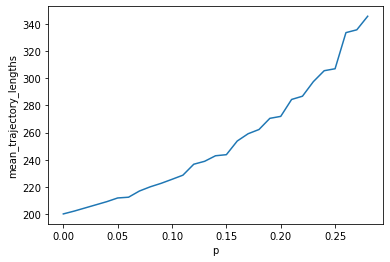

In [ ]:
sns.lineplot(data=df, x="p", y="mean_trajectory_lengths")
plt.show()

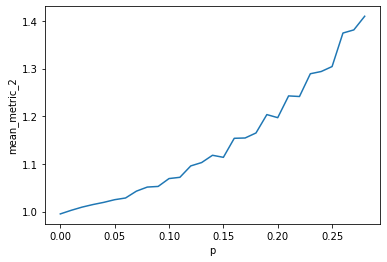

In [ ]:
sns.lineplot(data=df, x="p", y="mean_metric_2")
plt.show()

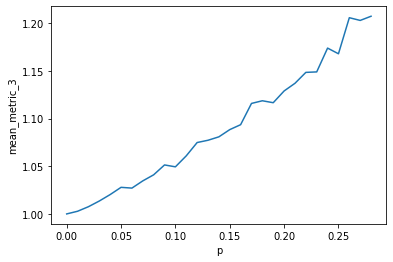

In [ ]:
sns.lineplot(data=df, x="p", y="mean_metric_3")
plt.show()

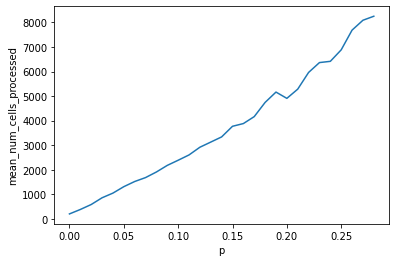

In [ ]:
sns.lineplot(data=df, x="p", y="mean_num_cells_processed")
plt.show()

In [ ]:
df.to_csv("q6_metrics.csv")

**Question 7: Performance Part 2** Generate and analyze the same data as in Q6, except using only the cell in the direction of attempted motion as the field of view. In other words, the agent may attempt to move in a given direction, and only discovers obstacles by bumping into them. How does the reduced field of view impact the performance of the algorithm?

In [ ]:
def q7(num_iters, dim_rows, dim_cols, densities, heuristic_fn):

  mean_traj_lengths, mean_num_cells_processed, mean_metric_2, mean_metric_3 = [], [], [], []

  for i in tqdm(range(len(densities))):
    p = densities[i]

    traj_lengths, traj_lengths_by_sp_final_discs, sp_final_disc_by_sp_fulls, num_cells_processed = [], [], [], []

    for i in range(num_iters):

      ras, _ = test_repeated_a_star_search_random((dim_rows, dim_cols), p, heuristic_fn, move_nbhd_type="directional")

      new_knowledge = block_undiscovered_nodes(ras.path_followed(), ras.knowledge_snaps[-1])

      shortest_path_final_discovered, exit_status_final_discovered, _ = \
        a_star_search((0, 0), (ras.grid.shape[0]-1, ras.grid.shape[1]-1), 
                      ras.grid.copy(), heuristic_fn, np.zeros(ras.grid.shape), 
                      new_knowledge)

      shortest_path_full, exit_status_full, _ = \
        a_star_search((0, 0), (ras.grid.shape[0]-1, ras.grid.shape[1]-1), 
                      ras.grid.copy(), heuristic_fn, np.zeros(ras.grid.shape), 
                      ras.grid.copy())

      trajectory_length = len(ras.path_followed())  # Metric 1
      traj_length_by_sp_final_disc = trajectory_length/len(shortest_path_final_discovered)  # Metric 2
      sp_final_disc_by_sp_full = len(shortest_path_final_discovered)/len(shortest_path_full)  # Metric 3
      total_cells_processed = ras.total_cells_processed()  # Metric 4

      traj_lengths.append(trajectory_length)
      traj_lengths_by_sp_final_discs.append(traj_length_by_sp_final_disc)
      sp_final_disc_by_sp_fulls.append(sp_final_disc_by_sp_full)
      num_cells_processed.append(total_cells_processed)

    mean_traj_lengths.append(np.mean(traj_lengths))
    mean_num_cells_processed.append(np.mean(num_cells_processed))
    mean_metric_2.append(np.mean(traj_lengths_by_sp_final_discs))
    mean_metric_3.append(np.mean(sp_final_disc_by_sp_fulls))

  df_res = pd.DataFrame({"p": densities, 
                         "mean_trajectory_lengths": mean_traj_lengths, 
                         "mean_metric_2": mean_metric_2, 
                         "mean_metric_3": mean_metric_3,
                         "mean_num_cells_processed": mean_num_cells_processed,})
  
  return df_res

In [ ]:
ras.grid

array([[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]])

In [ ]:
pretty_print(ras.knowledge_snaps[-1].astype(int))

   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
   0   1   1   1   0   0   0   1   0   0   0   0   0   1   0
   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
   0   0   0   0   0   0   0   0   0   0   0   1   0   1   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   0   0   1   0   1   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0


In [ ]:
pretty_print(visualize_grid(ras.path_followed(), ras.grid))

*   *   *   *   *   1   0   0   1   0   0   0   0   1   1   
0   1   1   1   *   *   *   1   0   0   0   0   0   1   0   
0   0   1   0   0   1   *   *   *   *   *   *   *   *   *   
1   1   1   0   1   1   1   0   0   0   0   1   0   0   *   
1   0   0   0   0   0   0   0   0   1   1   0   1   0   *   
0   1   1   0   0   0   0   0   1   0   0   0   0   *   *   
1   0   0   0   0   1   0   0   0   0   0   0   *   *   1   
0   0   0   0   0   0   0   0   0   0   0   0   *   1   0   
0   1   0   0   0   0   0   0   0   0   0   1   *   1   0   
0   1   1   1   0   0   0   1   0   0   0   0   *   *   1   
0   0   0   0   0   0   0   0   0   0   0   1   *   1   0   
0   0   1   0   0   0   0   0   1   0   0   0   *   1   0   
0   0   0   0   1   0   0   0   0   0   0   0   *   *   *   
0   0   0   0   0   0   1   1   0   0   1   0   0   0   *   
0   0   0   0   0   0   0   1   0   0   0   1   0   1   0   


In [ ]:
NUM_ITERS = 25
DIM_ROWS, DIM_COLS, P0 = 101, 101, 0.29
DENSITIES = np.arange(0, min(P0, 0.33), 0.01)
HEURISTIC_FN = "manhattan"

df_q7 = q7(NUM_ITERS, DIM_ROWS, DIM_COLS, DENSITIES, HEURISTIC_FN)

100%|██████████| 29/29 [05:37<00:00, 11.63s/it]


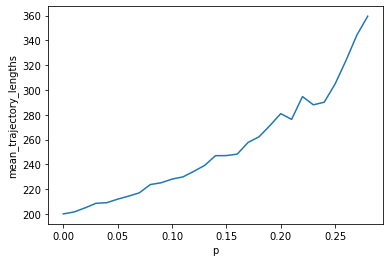

In [ ]:
sns.lineplot(data=df_q7, x="p", y="mean_trajectory_lengths")
plt.show()

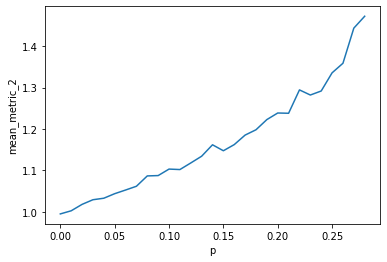

In [ ]:
sns.lineplot(data=df_q7, x="p", y="mean_metric_2")
plt.show()

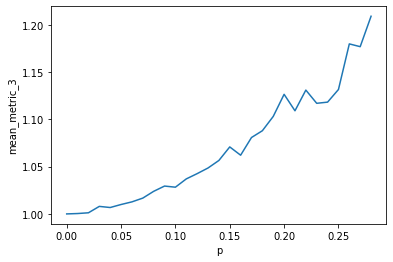

In [ ]:
sns.lineplot(data=df_q7, x="p", y="mean_metric_3")
plt.show()

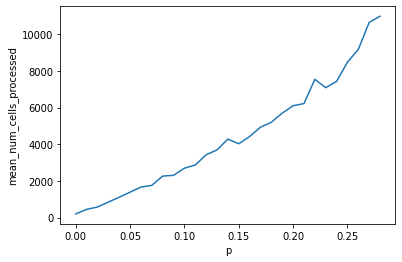

In [ ]:
sns.lineplot(data=df_q7, x="p", y="mean_num_cells_processed")
plt.show()

In [ ]:
df_q7.tail()

,p,mean_trajectory_lengths,mean_metric_2,mean_metric_3,mean_num_cells_processed
24,0.24,290.08,1.291868,1.118209,7430.04
25,0.25,304.80,1.335724,1.131557,8482.24
26,0.26,323.68,1.358830,1.179791,9177.40
27,0.27,344.16,1.443673,1.176855,10652.88
28,0.28,359.44,1.472382,1.209029,10986.52


In [ ]:
df_q7.to_csv("q7_metrics.csv")

**Question 8: Improvements** Repeated A-Star may suffer in that the best place to re-start A-Star from may not be where you currently are - for instance if you are at the dead end of a long hallway, you can save some effort by backtracking to the end of the hallway (recycling information you already have) before restarting the A-Star search. By changing where you restart the search process, can you cut down the overall runtime? What effect does this have on the overall trajectory (given that you have to travel between the current position and the new initial search position)?

In [ ]:
NUM_ITERS = 100
DIM_ROWS, DIM_COLS = 101, 101
DENSITY = 0.2
HEURISTIC_FN = "manhattan"

times, num_cells_processed, paths, path_lengths, backtracks = [], [], [], [], []

for i in tqdm(range(NUM_ITERS)):
  
  ras, time_taken = test_repeated_a_star_search_random((DIM_ROWS, DIM_COLS), DENSITY, HEURISTIC_FN, escape_tunnels=True)

  try:
    soln = ras.path_followed()
  except:
    continue

  times.append(time_taken)
  num_cells_processed.append(ras.total_cells_processed())

  total_path_length = len(soln) + ras.total_backtracked_cells()

  path_lengths.append(total_path_length)
  paths.append(soln)
  backtracks.append(ras.total_backtracked_cells())

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


In [ ]:
df_res = pd.DataFrame({ "time_taken": times, 
                       "num_cells_processed": num_cells_processed, 
                       "path_length": path_lengths,
                       "backtracked_cells": backtracks})

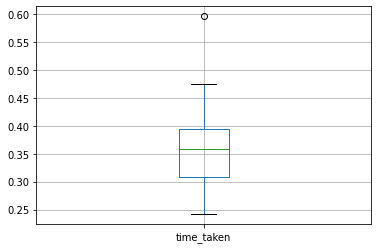

In [ ]:
df_res[['time_taken']].boxplot()
plt.show()

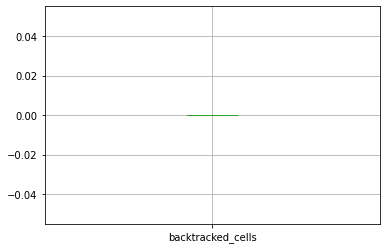

In [ ]:
df_res[['backtracked_cells']].boxplot()
plt.show()

In [ ]:
t0 = time.time()
ras1 = test_repeated_a_star_search_custom(escape_tunnels=True)
t1 = time.time()
# ras2 = test_repeated_a_star_search_custom(escape_tunnels=False)
# t2 = time.time()

In [ ]:
t1 - t0, t2 - t1

(0.01132512092590332, 0.006374359130859375)

In [ ]:
ras1.backtracks

[]

**Question 9: Heuristics** A-Star can frequently be sped up by the use of inadmissible heuristics - for instance weighted heuristics or combinations of heuristics. These can cut down on runtime potentially at the cost of path length. Can this be applied here? What is the effect of weighted heuristics on runtime and overall trajectory? Try to reduce the runtime as much as possible without too much cost to trajectory length.

In [ ]:
EPSILONS = np.arange(0, 10, 0.1)
DIM_ROWS, DIM_COLS = 101, 101
DENSITY = 0.2
HEURISTIC_FN = "manhattan"

grid = generate_gridworld((DIM_ROWS, DIM_COLS), DENSITY)

times, num_cells_processed, paths, path_lengths = [], [], [], []

for i in tqdm(range(len(EPSILONS))):
  e = EPSILONS[i]

  soln, exit_status, num_cells_popped = \
    a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, 
                  "manhattan", np.zeros(grid.shape), grid.copy(), epsilon=1.)
    
  if exit_status != "SUCCESS":
    print("Unsolvable grid, rerun cell!")
    break

  t0 = time.time()

  soln, exit_status, num_cells_popped = \
    a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, 
                  "manhattan", np.zeros(grid.shape), grid.copy(), epsilon=e)  
  
  time_taken = time.time() - t0

  times.append(time_taken)
  num_cells_processed.append(num_cells_popped)
  path_lengths.append(len(soln))
  paths.append(soln)

# print(len(EPSILONS))
# print(len(times))
# print(len(num_cells_processed))
# print(len(path_lengths))

df_res = pd.DataFrame({"epsilon": EPSILONS, "time_taken": times, "num_cells_processed": num_cells_processed, "path_length": path_lengths})

100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


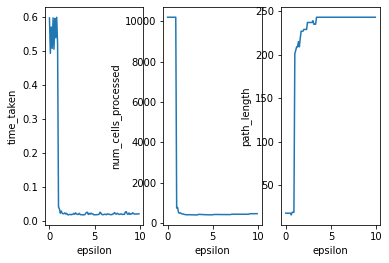

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, )
sns.lineplot(data=df_res, x="epsilon", y="time_taken", ax=ax1)
sns.lineplot(data=df_res, x="epsilon", y="num_cells_processed", ax=ax2)
sns.lineplot(data=df_res, x="epsilon", y="path_length", ax=ax3)
plt.subplots_adjust(hspace = 2.5)
plt.show()

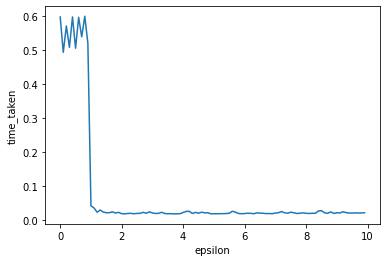

In [ ]:
sns.lineplot(data=df_res, x="epsilon", y="time_taken")
plt.show()

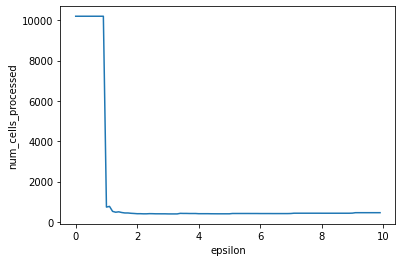

In [ ]:
sns.lineplot(data=df_res, x="epsilon", y="num_cells_processed")
plt.show()

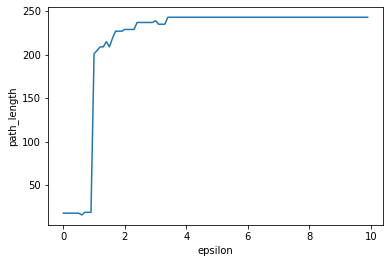

In [ ]:
sns.lineplot(data=df_res, x="epsilon", y="path_length")
plt.show()

In [ ]:
EPSILONS = np.arange(0, 10, 0.5)
DIM_ROWS, DIM_COLS = 101, 101
DENSITY = 0.2
HEURISTIC_FN = "manhattan"

grid = generate_gridworld((DIM_ROWS, DIM_COLS), DENSITY)

_, exit_status, _ = \
    a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, 
                  "manhattan", np.zeros(grid.shape), grid.copy(), epsilon=1.)
    
if exit_status != "SUCCESS":
  print("Not solvable!")


times, num_cells_processed, paths, path_lengths = [], [], [], []

for i in tqdm(range(len(EPSILONS))):
  e = EPSILONS[i]

  t0 = time.time()

  ras = RepeatedAStar(grid, epsilon=e)
  ras.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "manhattan")
  
  time_taken = time.time() - t0

  times.append(time_taken)
  num_cells_processed.append(ras.total_cells_processed())

  soln = ras.path_followed()

  path_lengths.append(len(soln))
  paths.append(soln)

df_res = pd.DataFrame({"epsilon": EPSILONS, "time_taken": times, "num_cells_processed": num_cells_processed, "path_length": path_lengths})

  0%|          | 0/20 [00:00<?, ?it/s]


ValueError: ignored

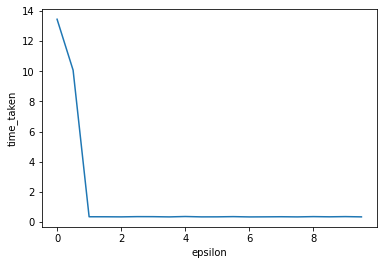

In [ ]:
sns.lineplot(data=df_res, x="epsilon", y="time_taken")
plt.show()

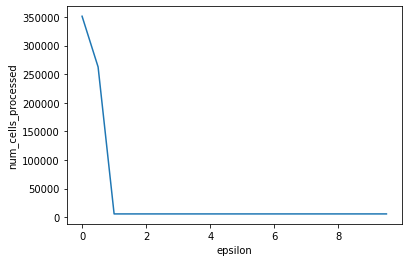

In [ ]:
sns.lineplot(data=df_res, x="epsilon", y="num_cells_processed")
plt.show()

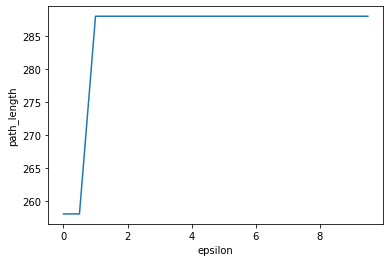

In [ ]:
sns.lineplot(data=df_res, x="epsilon", y="path_length")
plt.show()

In [ ]:
EPSILONS = np.arange(1, 10, 0.1)
DIM_ROWS, DIM_COLS = 15, 15
DENSITY = 0.2
HEURISTIC_FN = "manhattan"

times, num_cells_processed, paths, path_lengths, statuses = [], [], [], [], []

for i in tqdm(range(len(EPSILONS))):
  e = EPSILONS[i]

  grid = generate_gridworld((DIM_ROWS, DIM_COLS), DENSITY)

  t0 = time.time()

  ras = RepeatedAStar(grid, epsilon=e)
  ras.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "manhattan")
  
  time_taken = time.time() - t0

  times.append(time_taken)
  num_cells_processed.append(ras.total_cells_processed())

  soln = ras.path_followed()

  path_lengths.append(len(soln))
  paths.append(soln)
  statuses.append(ras.successfully_completed)

df_res = pd.DataFrame({"epsilon": EPSILONS, "time_taken": times, "num_cells_processed": num_cells_processed, "path_length": path_lengths})

  7%|▋         | 6/90 [00:00<00:01, 61.61it/s]


ValueError: ignored

In [ ]:
df_res

,epsilon,time_taken,num_cells_processed,path_length
0,1.0,0.010759,160,36
1,1.1,0.009702,160,36
2,1.2,0.010705,160,36
3,1.3,0.009733,160,36
4,1.4,0.010309,160,36
...,...,...,...,...
85,9.5,0.009102,160,36
86,9.6,0.009721,160,36
87,9.7,0.013407,160,36
88,9.8,0.011967,160,36


In [ ]:
pretty_print(grid)
print("\n")

for i in range(len(EPSILONS)):
  print("epsilon =", EPSILONS[i])
  pretty_print(visualize_grid(paths[i], grid))
  print("\n")

**Extra Credit**: Repeat Q6, Q7, using Repeated BFS instead of Repeated A*. Compare the two approaches. Is Repeated BFS ever preferable? Why or why not? Be as thorough and as explicit as possible.

In [ ]:
class Node:
  
  def __init__(self, parent=None, position=None, ):
    """ Represents a Node in the BFS search tree. """

    self.parent = parent
    self.position = position
  
  def __eq__(self,other):
    """ For Node comparison. """
    if type(self) != type(other):
      return False

    return self.position == other.position
  



def is_unvisited_and_unblocked(coords, state):
  """Removes visited and blocked cells"""

  x, y = coords
  knowledge, visited= state

  if knowledge[x][y] != 0 or visited[x][y] != 0 :
    return False

  return True

def neighbourhood(coords, num_rows, num_cols):
  # Get possible cells
  x, y = coords
  possible_cells = [(x-1, y), (x, y-1), (x+1, y), (x, y+1)]

  # Remove cells outside boundaries
  possible_cells = [cell for cell in possible_cells if cell[0] >= 0 and cell[1] >= 0 and cell[0] <= num_rows-1 and cell[1] <= num_cols-1]

  return possible_cells


def get_valid_children(coords, parent, num_rows, num_cols, state):
  """Assume grid: [(0, 0) -> (num_rows-1, num_cols-1)]"""

  # Get all possible children
  nbhd = neighbourhood(coords, num_rows, num_cols)

  if parent is not None:
    nbhd = [x for x in nbhd if x != parent.position]

  # Remove known blocked and visited cells
  valid_children = [cell for cell in nbhd if is_unvisited_and_unblocked(cell, state)]

  return valid_children

In [ ]:
def grid_path(current_node):
    """ Recursively finds the path from the leaf to the root node in the A* search tree. """
    path = []

    current = current_node
    while current != None:
      path.append(current.position)
      current = current.parent

    return path[::-1]
  
def bfs_search(start, goal, grid, visited, knowledge, max_steps=None):

  start_node = Node(None, start)
  goal_node = Node(None, goal)

  # Implementing priority queue using heap
  fringe = []
  
  fringe.append(start_node)

  # Stopping condition
  if max_steps is None:
    max_steps = grid.shape[0] * grid.shape[1]

  steps = 0
  exit_status = "FAILED_NOPATH"

  # Start
  while fringe:
    
    steps += 1

    # Pop the current node from the fringe
    current_node = fringe.pop(0)
    curr_x, curr_y = current_node.position

    # Visit the current node and note that it is out of the fringe
    visited[curr_x][curr_y] = 1
    

    # Check and return path if we have reached the goal node
    if current_node == goal_node:
      exit_status = "SUCCESS"
      return grid_path(current_node), exit_status

    # Stopping condition
    if steps > max_steps:
      exit_status = "FAILED_STEPS"
      return grid_path(current_node), exit_status

    # Create children
    children = get_valid_children(current_node.position, current_node.parent, grid.shape[0], grid.shape[1], (knowledge, visited))
    children = [Node(current_node, x) for x in children]

    for i in range(len(children)):
      #children[i].g = current_node.g + 1
      #children[i].h = heuristic(heuristic_type, children[i].position, goal)
      #children[i].f = children[i].g + children[i].h
      #children[i].recency_factor = recency_counter
      
      #heapq.heappush(fringe, children[i])
      fringe.append(children[i])
      

      #recency_counter += 1

  return [], exit_status

In [ ]:
class Repeated_BFS:

  def __init__(self, grid):
    self.knowledge_snaps = []
    self.visited_snaps = []
    self.start_end_snaps = []
    self.sol_snaps = []
    self.step = 0
    self.successfully_completed = False
    self.final_exit_status = None
    self.grid = grid

  def _update_state(self, knowledge, visited, path_end_points, soln, step, successfully_completed, final_exit_status):
    self.knowledge_snaps.append(knowledge)
    self.visited_snaps.append(visited)
    self.start_end_snaps.append(path_end_points)
    self.sol_snaps.append(soln)
    self.step = step
    self.successfully_completed = successfully_completed
    self.final_exit_status = final_exit_status

  def logs(self):
    return {
        "grid": self.grid,
        "knowledge": self.knowledge_snaps,
        "visited": self.visited_snaps,
        "start_end": self.start_end_snaps,
        "solns": self.sol_snaps,
        "num_steps": self.step,
        "successfully_completed": self.successfully_completed,
        "final_exit_status": self.final_exit_status
    }

  def path_followed(self):
    """ Returns the actual path followed (planning + execution) """

    # If the paths followed and solutions don't match
    assert len(self.sol_snaps) == len(self.start_end_snaps), \
      "More steps for A* than elements in start_end."
    
    full_path = []
    for i in range(len(self.start_end_snaps)):

      # Get index of end node in path
      _, end_node = self.start_end_snaps[i]
      end_index = self.sol_snaps[i].index(end_node)

      # Clip the array according to end index and append to parent array
      clipped_array = self.sol_snaps[i][:end_index]
      full_path += clipped_array

    return full_path

  def search(self, start, goal, grid, max_steps_bfs=None, max_steps_repeated=None):

    # Exit condition
    if max_steps_repeated is None:
      max_steps_repeated = grid.shape[0]*grid.shape[1]

    # Initialize visited matrix, knowledge matrix and planned_path array
    # visited = np.zeros(grid.shape)
    knowledge = np.zeros(grid.shape)
    planned_path = []
    
    # Start
    while not self.successfully_completed:

      # If number of steps have been exceeded for Repeated A*
      if self.step > max_steps_repeated:
        self._update_state(None, None, (None, None), None, self.step, False, "FAILED_STEPS_REP")
        return

      visited = np.zeros(grid.shape)

      # Run A* search algorithm once
      planned_path, exit_status = bfs_search(start, goal, grid, visited, knowledge, max_steps=max_steps_bfs)

      if exit_status == "FAILED_NOPATH": # If no path can be found
        self._update_state(knowledge, visited, (start, None), planned_path, self.step + 1, False, exit_status)
        return

      elif exit_status == "FAILED_STEPS": # If num of steps were exceeded for one run of A*
        self._update_state(knowledge, visited, (start, None), planned_path, self.step + 1, False, exit_status)
        return

      # Move robot along the grid on the planned path and record environment
      final_node, knowledge, _ = move_and_record(start, goal, grid, planned_path, knowledge)

      # If we were able to reach the goal successfully
      if final_node == goal:
        self._update_state(knowledge, visited, (start, final_node), planned_path, self.step + 1, True, "SUCCESS")
        continue

      # If we were not able to reach the goal successfully, repeat until possible
      self._update_state(knowledge, visited, (start, final_node), planned_path, self.step + 1, False, "RUNNING")
      start = final_node

    # We were able to reach successfully
    return

In [ ]:
  grid = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
          [0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
          [0, 1, 1, 1, 1, 0, 0, 0, 1, 1],
          [0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
  grid=np.array(grid)
  repeated_bfs = Repeated_BFS(grid)
  repeated_bfs.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid)

In [ ]:
print(repeated_a_star.final_exit_status)
pretty_print(visualize_grid(ras.path_followed(), ras.knowledge_snaps[-1].astype(int)))